# Wczytanie danych

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lux

In [2]:
df = pd.read_csv("../Data/data_for_presentation.xz", compression="xz")

/home/pk/miniconda3/envs/Hackathon-2021-RTFD/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

# Analiza danych

## Korelogram

<AxesSubplot:>

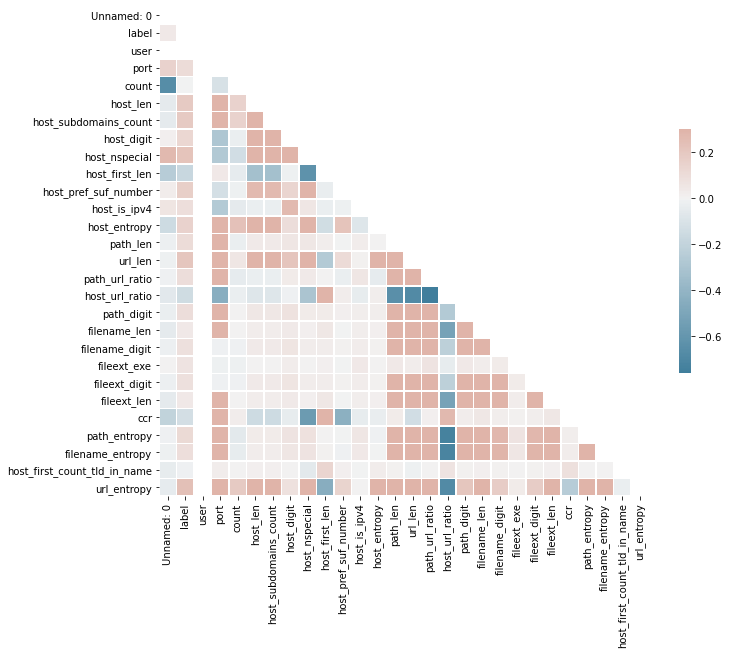

In [4]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Histplot

In [45]:
df.columns

Index(['Unnamed: 0', 'url', 'label', 'scheme', 'user', 'host', 'port', 'path',
       'query', 'fragment', 'filename', 'fileext', 'tld', 'count', 'host_len',
       'host_subdomains_count', 'host_digit', 'host_nspecial',
       'host_first_len', 'host_pref_suf_number', 'host_is_ipv4',
       'host_entropy', 'path_len', 'url_len', 'path_url_ratio',
       'host_url_ratio', 'path_digit', 'filename_len', 'filename_digit',
       'fileext_exe', 'fileext_digit', 'fileext_len', 'ccr', 'path_entropy',
       'filename_entropy', 'host_first_count_tld_in_name', 'url_entropy'],
      dtype='object')

<AxesSubplot:xlabel='host_subdomains_count', ylabel='Count'>

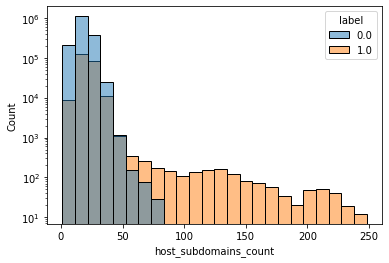

In [68]:
sns.histplot(data=df, x='host_subdomains_count', log_scale=(False, True),bins=24, hue='label')

In [84]:
df.loc[df.host_subdomains_count > 200, "url"].to_numpy()[0]

'paypal.com.com.cgi.bin.webscr.cmd.login.submit.dispatch.5885d80a13c0db1f8e263663d3fa.ee8d0b7e678a25d88.3d0fa72c947f193f8fd.5885d80a13c0db1f8e263663d3fa.ee8d0b7e678a25d88.3d0fa72c947f193f8fd.rtcollege.net'

## Przygotowanie danych 

In [5]:
df['label'].value_counts()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

`label` to kategoria, którą będziemy przewidywać. Powyższy kod zlicza ile poszczególnych kategorii występuje w danej kolumnie. W tym przypadku problem jest __niezbalansowany__ tj. pewne klasy występują częściej niż inne. Tutaj `0 - dobry link` występuje znacznie częściej niż `1 - zły link`. Z tego powodu wymagane będzie ich __zbalansowanie__. Do balansowania klas wykorzystuje się najczęściej dwie metody (są też inne np. [Tomek(T-Links)](https://www.analyticsvidhya.com/blog/2020/11/handling-imbalanced-data-machine-learning-computer-vision-and-nlp/):
- Upsampling - stworzymy więcej próbek dla klas, które są mniejsze np. duplikując część z nich
- Downsampling - wybierzemy losowo próbę z największych klas, która będzie równie liczna jak klasy mniejsze

W tym przypadku wybrałem downsampling, ponieważ bardziej zależy mi na przewidywaniu klasy mniej licznej. W ten sposób, dane z niej nie zostaną powielone i łatwiej będzie odczytać raport z klasyfikacji.

### Downsampling

In [6]:
from sklearn.utils import resample
# Oddzielam klasy
df_majority = df[df.label==0]
df_minority = df[df.label==1]
 
# Wybieram losową próbę z większej z klas
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # Bez powtarzania
                                 n_samples=len(df_minority), # O liczności mniejszej z klas
                                 random_state=123) # Ustawiam aby wyniki były powtarzalne
 
# Łączę obie klasy
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Wyświetlam ilość próbek w każdej z klas
df_downsampled.label.value_counts()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [7]:
X, y = df_downsampled.iloc[:,13:].to_numpy(), df_downsampled.loc[:, "label"].astype("int").to_numpy()

In [8]:
import autosklearn.classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import sklearn.metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

sc = StandardScaler().fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

# Trenowanie Lasu losowego

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X_train, y_train)

print(sklearn.metrics.classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83     58259
           1       0.80      0.93      0.86     58259

    accuracy                           0.84    116518
   macro avg       0.85      0.84      0.84    116518
weighted avg       0.85      0.84      0.84    116518



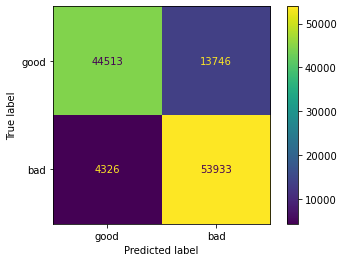

In [37]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["good", "bad"])
disp.plot() 

# Pytorch

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [12]:
EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [13]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [14]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [26]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 24.
        self.layer_1 = nn.Linear(24, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [28]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=24, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [29]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [30]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.33169 | Acc: 86.546
Epoch 002: | Loss: 0.30817 | Acc: 87.733
Epoch 003: | Loss: 0.30346 | Acc: 87.954
Epoch 004: | Loss: 0.29970 | Acc: 88.183
Epoch 005: | Loss: 0.29694 | Acc: 88.278
Epoch 006: | Loss: 0.29403 | Acc: 88.367
Epoch 007: | Loss: 0.29377 | Acc: 88.393
Epoch 008: | Loss: 0.29211 | Acc: 88.378
Epoch 009: | Loss: 0.29120 | Acc: 88.430
Epoch 010: | Loss: 0.28918 | Acc: 88.538
Epoch 011: | Loss: 0.28879 | Acc: 88.533
Epoch 012: | Loss: 0.28819 | Acc: 88.557
Epoch 013: | Loss: 0.28739 | Acc: 88.559
Epoch 014: | Loss: 0.28691 | Acc: 88.585
Epoch 015: | Loss: 0.28617 | Acc: 88.620
Epoch 016: | Loss: 0.28631 | Acc: 88.601
Epoch 017: | Loss: 0.28511 | Acc: 88.624
Epoch 018: | Loss: 0.28451 | Acc: 88.655
Epoch 019: | Loss: 0.28503 | Acc: 88.678


KeyboardInterrupt: 

In [31]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [32]:
confusion_matrix(y_test, y_pred_list)

array([[48943,  9316],
       [ 3631, 54628]])

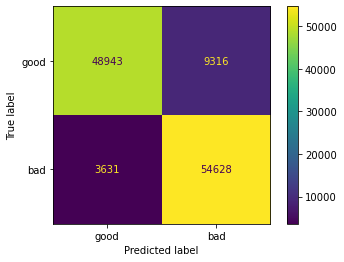

In [38]:
cm2 = confusion_matrix(y_test, y_pred_list, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=["good", "bad"])
disp.plot() 

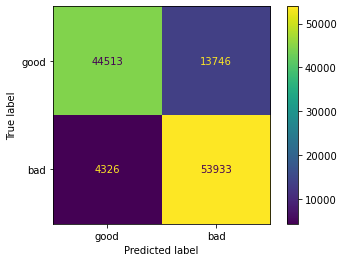

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["good", "bad"])
disp.plot() 